# Plots for Figure 4

In [1]:
###Load Packages
#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]

In [3]:
#path to the data
path = "../../"

## Poly(A) tail lengths per gene

In [4]:
#Function to read polyA tab del files
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [5]:
#Read in dfs for all reads
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/EV.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/EV.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/WT.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/WT.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/4SA.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/4SA.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/4SD.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/4SD.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)
all_reads["gene_id"] = all_reads["gene_id"].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

In [6]:
#Function to read polyA tab del files AFTER running get_tails.py
def read_polyA_gene(file, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [7]:
#Read in dfs for gene tail metrics
per_gene_h112_1 = read_polyA_gene(path + "results/polyA_len/per_gene/EV.R1_per_gene.tsv", "EV", "1")
per_gene_h112_2 = read_polyA_gene(path + "results/polyA_len/per_gene/EV.R2_per_gene.tsv", "EV", "2")

per_gene_h113_1 = read_polyA_gene(path + "results/polyA_len/per_gene/WT.R1_per_gene.tsv", "WT", "1")
per_gene_h113_2 = read_polyA_gene(path + "results/polyA_len/per_gene/WT.R2_per_gene.tsv", "WT", "2")

per_gene_h115_1 = read_polyA_gene(path + "results/polyA_len/per_gene/4SA.R1_per_gene.tsv", "4SA", "1")
per_gene_h115_2 = read_polyA_gene(path + "results/polyA_len/per_gene/4SA.R2_per_gene.tsv", "4SA", "2")

per_gene_h117_1 = read_polyA_gene(path + "results/polyA_len/per_gene/4SD.R1_per_gene.tsv", "4SD", "1")
per_gene_h117_2 = read_polyA_gene(path + "results/polyA_len/per_gene/4SD.R2_per_gene.tsv", "4SD", "2")

#Concatenate samples and conditions into single dataframes
df_gene = pd.concat([per_gene_h112_1, per_gene_h112_2, per_gene_h113_1, per_gene_h113_2, per_gene_h115_1, per_gene_h115_2, per_gene_h117_1, per_gene_h117_2])

df_gene = df_gene.loc[df_gene['median'] >= 10]
df_gene.rename(columns={"Unnamed: 0":'gene_id'}, inplace=True)

df_gene.gene_id = df_gene.gene_id.str.split(".").str[0]
#Path to gene types df (from gtf)
gene_types = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
df_gene = df_gene.merge(gene_types, on = 'gene_id')

In [8]:
#Define a function to compare tail lengths per gene between two conditions
def compare_tail_lengths(df, c1, c2, min_reads=25):
    #select genes that are common between conditions
    c1_genes = df.loc[df.Sample == c1].gene_id
    common_genes = list(np.unique(df.loc[(df.Sample == c2) & df.gene_id.isin(c1_genes)].gene_id ))
    #calculate summary stats of each gene between conditions and test for statistical significance 
    per_gene_res_c1 = dict()
    per_gene_res_c2 = dict()
    reads_c1 = df.loc[df["Sample"] == c1]
    reads_c2 = df.loc[df["Sample"] == c2]
    for i in tqdm(np.unique(common_genes)):
        temp_c1 = reads_c1[reads_c1.gene_id == i]
        temp_c2 = reads_c2[reads_c2.gene_id == i]
        if (len(temp_c1) & len(temp_c2)) >= min_reads:
            per_gene_res_c1[i] = [np.mean(temp_c1.tail_len), np.median(temp_c1.tail_len), pearson_skew_2(temp_c1.tail_len), len(temp_c1.tail_len)]
            per_gene_res_c2[i] = [np.mean(temp_c2.tail_len), np.median(temp_c2.tail_len), pearson_skew_2(temp_c2.tail_len), len(temp_c2.tail_len), np.unique(temp_c1.gene_name)[0], stats.mannwhitneyu(temp_c1.tail_len, temp_c2.tail_len).pvalue]
    
    #build a dataframe for results output
    per_gene_c1 = pd.DataFrame.from_dict(per_gene_res_c1, orient='index', columns=[('mean' + "_" + c1), 'median'+ "_" + c1, 'skew'+ "_" + c1, 'n'+ "_" + c1])
    per_gene_c2 = pd.DataFrame.from_dict(per_gene_res_c2, orient='index', columns=[('mean' + "_" + c2), 'median'+ "_" + c2, 'skew'+ "_" + c2, 'n'+ "_" + c2, "gene_name", "pvalue"])
    per_gene_df = per_gene_c1.join(per_gene_c2)
    #correct pvalues for sample size (BH correction)
    per_gene_df["FDR"] = stats.false_discovery_control(per_gene_df["pvalue"])
    per_gene_df["log2FC"] = np.log2(per_gene_df["median_" + c2]/per_gene_df["median_" + c1])
    
    return(per_gene_df)

In [15]:
#Define cuttoffs for fold change and significance
FC_cut = 0
pcut = 0.05

In [9]:
#Compare WT to 4SA
WT_v_4SA = compare_tail_lengths(all_reads, "4SA", "WT", 10)

  0%|                                                                                                                            | 0/12298 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12298/12298 [12:18<00:00, 16.65it/s]


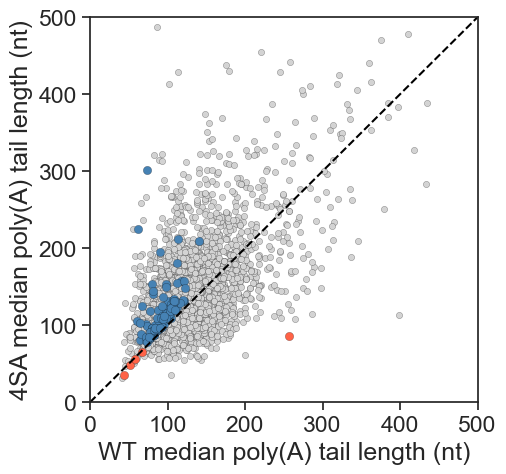

In [16]:
#4SA vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = WT_v_4SA, x = "median_WT", y = "median_4SA", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = WT_v_4SA.loc[(WT_v_4SA["log2FC"] >= FC_cut) & (WT_v_4SA["FDR"] <= pcut)], x = "median_WT", y = "median_4SA", color = "tomato", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = WT_v_4SA.loc[(WT_v_4SA["log2FC"] <= -FC_cut) & (WT_v_4SA["FDR"] <= pcut)], x = "median_WT", y = "median_4SA", color = "steelblue", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("WT median poly(A) tail length (nt)")
ax.set_ylabel("4SA median poly(A) tail length (nt)")


plt.show()

In [17]:
#Compare WT to 4SD
WT_v_4SD = compare_tail_lengths(all_reads, "4SD", "WT", 10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10605/10605 [06:39<00:00, 26.53it/s]


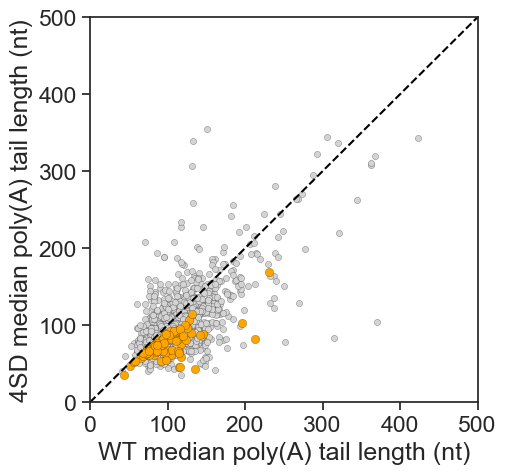

In [18]:
#4SD vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = WT_v_4SD, x = "median_WT", y = "median_4SD", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = WT_v_4SD.loc[(WT_v_4SD["log2FC"] >= FC_cut) & (WT_v_4SD["FDR"] <= pcut)], x = "median_WT", y = "median_4SD", color = "orange", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = WT_v_4SD.loc[(WT_v_4SD["log2FC"] <= -FC_cut) & (WT_v_4SD["FDR"] <= pcut)], x = "median_WT", y = "median_4SD", color = "tomato", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("WT median poly(A) tail length (nt)")
ax.set_ylabel("4SD median poly(A) tail length (nt)")

plt.show()

In [19]:
#Compare 4SA to 4SD
SA_v_SD = compare_tail_lengths(all_reads, "4SD", "4SA", 10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10761/10761 [08:09<00:00, 22.01it/s]


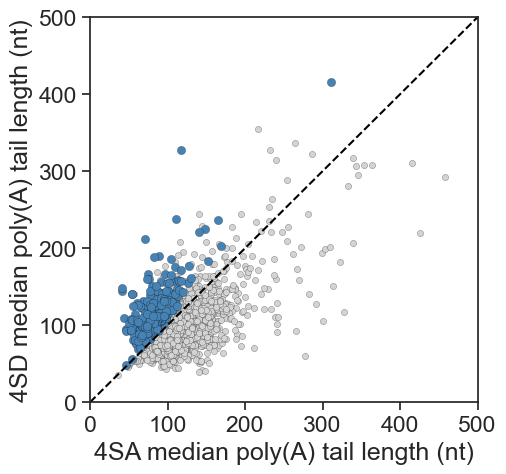

In [23]:
#4SD vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = SA_v_SD, x = "median_4SA", y = "median_4SD", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] >= FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "median_4SD", y = "median_4SA", color = "steelblue", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] <= -FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "median_4SD", y = "median_4SA", color = "orange", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("4SA median poly(A) tail length (nt)")
ax.set_ylabel("4SD median poly(A) tail length (nt)")

plt.show()

In [24]:
gene_list = ["GAPDH", "HNRNPA2B1", "XIST", "ATF4", "CDK1"]

reads_to_plot = all_reads.loc[all_reads.gene_name.isin(gene_list)]
print("p-values")
for gene in np.unique(reads_to_plot.gene_name):
    s = stats.mannwhitneyu(list(reads_to_plot.loc[(all_reads["Sample"] == "4SA") & (all_reads["gene_name"] == gene)].tail_len), 
                    list(reads_to_plot.loc[(all_reads["Sample"] == "4SD") & (all_reads["gene_name"] == gene)].tail_len), 
                    axis=0)
    print(gene + ": " + str(s.pvalue))

p-values
ATF4: 4.044502116319512e-06
CDK1: 0.00018959622326657511
GAPDH: 2.3193187576954275e-17
HNRNPA2B1: 0.0020905697783327073
XIST: 0.010747523896498056


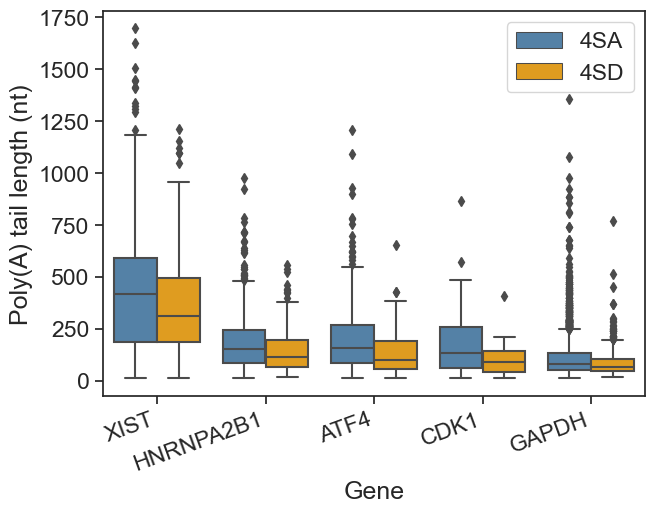

In [32]:
f, ax = plt.subplots(1,1, figsize = (7,5))

sns.boxplot(data = reads_to_plot.loc[(reads_to_plot.Sample == "4SA") |(reads_to_plot.Sample == "4SD")], x = "gene_name", y = "tail_len", palette = two_palette, hue = "Sample")


ax.set_ylabel("Poly(A) tail length (nt)")
ax.set_xlabel("Gene")
plt.xticks(rotation=20, ha='right')
plt.legend(loc = 'best')


plt.show()

## Poly(A) tail lengths per splice isoform

In [34]:
#Color palette for plots
IR_palette = ["goldenrod", "teal"]

In [72]:
#Read in dfs for all reads - annotated to mapped isoform instead of mapped gene
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_EV.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_EV.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_WT.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_WT.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_4SA.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_4SA.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_4SD.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_4SD.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

# #Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)

In [73]:
# load the results from tab del files for isoform specific mapping
per_gene_h112_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_EV.R1_per_gene.tsv", "EV", "1")
per_gene_h112_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_EV.R2_per_gene.tsv", "EV", "2")

per_gene_h113_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_WT.R1_per_gene.tsv", "WT", "1")
per_gene_h113_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_WT.R2_per_gene.tsv", "WT", "2")

per_gene_h115_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_4SA.R1_per_gene.tsv", "4SA", "1")
per_gene_h115_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_4SA.R2_per_gene.tsv", "4SA", "2")

per_gene_h117_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_4SD.R1_per_gene.tsv", "4SD", "1")
per_gene_h117_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_4SD.R2_per_gene.tsv", "4SD", "2")

#Concatenate samples and conditions into single dataframes
df_isos = pd.concat([per_gene_h112_1, per_gene_h112_2, per_gene_h113_1, per_gene_h113_2, per_gene_h115_1, per_gene_h115_2, per_gene_h117_1, per_gene_h117_2])

df_isos = df_isos.loc[df_isos['median'] >= 10]
df_isos.rename(columns={"Unnamed: 0":'iso_id'}, inplace=True)

#Path to gene types df (from gtf)
gene_types = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/gene_types_df.tsv", sep = "\t")
df_isos["gene_id"] = df_isos.iso_id.str.split("_").str[-1].str.split(".").str[0]

#Combine replicates and intersect with gene names
df_isos = df_isos.merge(gene_types, on = 'gene_id')

In [74]:
#Determine which isoforms have retained introns using flair mark IR tool
mark_IR = pd.read_csv(path + "results/splicing/IR/IR_isoforms.bed", sep = "\t", header = None)
IR_isoforms = list(mark_IR.loc[mark_IR[12] == 1][3])

df_isos.loc[df_isos.iso_id.isin(IR_isoforms), "IR"] = "IR"
df_isos.loc[~df_isos.iso_id.isin(IR_isoforms), "IR"] = "Spliced"

In [75]:
#Reformat the all_reads df to contain info on gene types
all_reads.loc[all_reads.gene_id.isin(IR_isoforms), "IR"] = "IR"
all_reads.loc[~all_reads.gene_id.isin(IR_isoforms), "IR"] = "Spliced"
all_reads = all_reads.rename(columns={"gene_id": "iso_id"})
all_reads["gene_id"] = all_reads.iso_id.str.split("_").str[-1].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

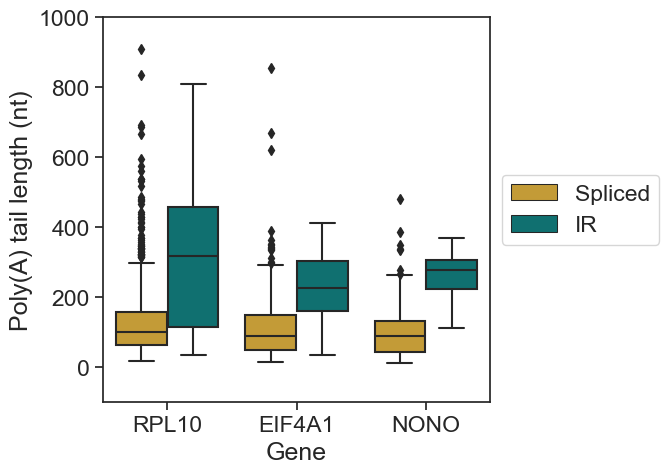

In [78]:
#Plot to compare tail lengths of spliced to unspliced isoforms
gene_list = ["RPL10", "EIF4A1", "NONO"]
condition1 = "4SA"
comparision = "tail_len"
Sample = "Sample"

reads_to_plot = all_reads.loc[(all_reads["gene_name"].isin(gene_list))]
reads_to_plot = reads_to_plot.loc[(reads_to_plot["Sample"] == condition1)] 

# Plot with seaborn
f, (ax) = plt.subplots(1,1, figsize = (5, 5))

sns.boxplot(data=reads_to_plot, x = "gene_name", y = "tail_len", hue = "IR", palette = IR_palette, order = gene_list)
ax.set_ylabel("Poly(A) tail length (nt)")
ax.set_xlabel("Gene")
ax.set_ylim(-100, 1500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-100, 1000)

plt.show()

In [86]:
#Define a function to compare tail lengths per gene between two conditions (for isoforms)
def compare_tail_lengths_iso(df, c1, c2, min_reads=25):
    #select genes that are common between conditions
    c1_genes = df.loc[df.Sample == c1].iso_id
    common_genes = list(np.unique(df.loc[(df.Sample == c2) & df.iso_id.isin(c1_genes)].iso_id ))
    #calculate summary stats of each gene between conditions and test for statistical significance 
    per_gene_res_c1 = dict()
    per_gene_res_c2 = dict()
    reads_c1 = df.loc[df["Sample"] == c1]
    reads_c2 = df.loc[df["Sample"] == c2]
    for i in tqdm(np.unique(common_genes)):
        temp_c1 = reads_c1[reads_c1.iso_id == i]
        temp_c2 = reads_c2[reads_c2.iso_id == i]
        if (len(temp_c1) & len(temp_c2)) >= min_reads:
            per_gene_res_c1[i] = [np.mean(temp_c1.tail_len), np.median(temp_c1.tail_len), pearson_skew_2(temp_c1.tail_len), len(temp_c1.tail_len)]
            per_gene_res_c2[i] = [np.mean(temp_c2.tail_len), np.median(temp_c2.tail_len), pearson_skew_2(temp_c2.tail_len), len(temp_c2.tail_len), np.unique(temp_c1.gene_name)[0], stats.mannwhitneyu(temp_c1.tail_len, temp_c2.tail_len).pvalue]
    
    #build a dataframe for results output
    per_gene_c1 = pd.DataFrame.from_dict(per_gene_res_c1, orient='index', columns=[('mean' + "_" + c1), 'median'+ "_" + c1, 'skew'+ "_" + c1, 'n'+ "_" + c1])
    per_gene_c2 = pd.DataFrame.from_dict(per_gene_res_c2, orient='index', columns=[('mean' + "_" + c2), 'median'+ "_" + c2, 'skew'+ "_" + c2, 'n'+ "_" + c2, "gene_name", "pvalue"])
    per_gene_df = per_gene_c1.join(per_gene_c2)
    #correct pvalues for sample size (BH correction)
    per_gene_df["FDR"] = stats.false_discovery_control(per_gene_df["pvalue"])
    per_gene_df["log2FC"] = np.log2(per_gene_df["median_" + c2]/per_gene_df["median_" + c1])
    
    return(per_gene_df)

In [87]:
#Run the comparison function
SA_v_SD_isos = compare_tail_lengths_iso(all_reads, "4SD", "4SA", 10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7105/7105 [02:59<00:00, 39.59it/s]


In [89]:
#Reintigrate the info about intron retention
SA_v_SD_isos.loc[SA_v_SD_isos.index.isin(IR_isoforms), "IR"] = "IR"
SA_v_SD_isos.loc[~SA_v_SD_isos.index.isin(IR_isoforms), "IR"] = "Spliced"

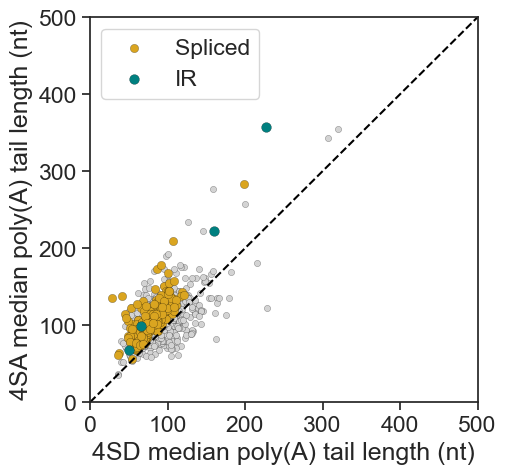

In [93]:
#4SD vs 4SD
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = SA_v_SD_isos, x = "median_4SD", y = "median_4SA", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD_isos.loc[(SA_v_SD_isos["IR"] == "Spliced") & (SA_v_SD_isos["FDR"] <= 0.05)], x = "median_4SD", y = "median_4SA", color = IR_palette[0], edgecolor = "black", linewidth = 0.15, label = "Spliced")
sns.scatterplot(data = SA_v_SD_isos.loc[(SA_v_SD_isos["IR"] == "IR") & (SA_v_SD_isos["FDR"] <= 0.05)], x = "median_4SD", y = "median_4SA", color = IR_palette[1], edgecolor = "black", linewidth = 0.15, s = 50, label = "IR")

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("4SD median poly(A) tail length (nt)")
ax.set_ylabel("4SA median poly(A) tail length (nt)")

plt.show()